In [1]:
!git clone https://github.com/elenadigrigoli/FDS-project.git

Cloning into 'FDS-project'...
remote: Enumerating objects: 43615, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 43615 (delta 45), reused 42 (delta 19), pack-reused 43538 (from 1)
Receiving objects: 100% (43615/43615), 1.22 GiB | 26.11 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Updating files: 100% (21723/21723), done.


In [12]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf
from skimage import io, color, transform
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from PIL import Image
from xgboost import XGBClassifier
from preprocessing import *
from machine_learning import *
import cv2 as cv
import seaborn as sns

### Load data

In [2]:
train_folder = 'final dataset/train'
test_folder = 'final dataset/test'

### Load images in the right format for scikit-learn.

In [3]:
train_images, train_labels, class_names = load_images(train_folder, image_size=(224,224), gray=False)
images = train_images.astype(np.float32)

In [4]:
test_images, test_labels, class_names_test = load_images(test_folder, image_size=(224,224), gray=False)
test_images = test_images.astype(np.float32)

## Preprocessing the images

### Image normalization

In [5]:
# Image normalization
images /= 255.0
test_images /= 255.0

### Remove noise from images using Gaussian Blur.

In [6]:
for i in range(len(images)):
    images[i] = cv.GaussianBlur(images[i], (5, 5), 0)

## **Classification using color histograms**

### Compute color histograms and flatten images

In [7]:
# Compute color histograms for training set
feature_vectors = []
for img in images:
    feature_vector = calculate_histograms(img, norm=True) 
    feature_vector /= feature_vector.sum()  # Histogram normalization
    feature_vectors.append(feature_vector)
x_train = np.array(feature_vectors)  # Convert histogram to np array

In [8]:
# Compute color histograms for test set
feature_vectors = []
for img in test_images:
    feature_vector = calculate_histograms(img, norm=True)
    if feature_vector.sum()!=0:
        feature_vector /= feature_vector.sum()
    feature_vectors.append(feature_vector)
x_test = np.array(feature_vectors)

### XGBoost with Color Histograms

In [9]:
model = XGBClassifier(n_estimators = 200, learning_rate = 0.05, max_depth=6, objective="multi:softmax", reg_lambda = 5, reg_alpha = 0.5, random_state=42)
model.fit(x_train, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [10]:
y_pred_train = model.predict(x_train)
print(classification_report(train_labels, y_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1200
           1       0.87      0.90      0.89      1200
           2       0.90      0.87      0.89      1448
           3       0.82      0.97      0.89      4258
           4       0.91      0.89      0.90      2431
           5       0.90      0.80      0.85      1200
           6       0.85      0.81      0.83      1320
           7       0.92      0.83      0.87      1532
           8       0.91      0.72      0.80      1581
           9       0.92      0.90      0.91      1200

    accuracy                           0.88     17370
   macro avg       0.89      0.86      0.87     17370
weighted avg       0.88      0.88      0.88     17370



In [11]:
y_pred = model.predict(x_test)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43       300
           1       0.45      0.65      0.53       300
           2       0.66      0.43      0.52       362
           3       0.70      0.82      0.76      1065
           4       0.52      0.60      0.56       608
           5       0.39      0.36      0.37       300
           6       0.47      0.38      0.42       330
           7       0.53      0.48      0.50       383
           8       0.37      0.39      0.38       396
           9       0.59      0.54      0.56       300

    accuracy                           0.56      4344
   macro avg       0.53      0.50      0.50      4344
weighted avg       0.56      0.56      0.55      4344



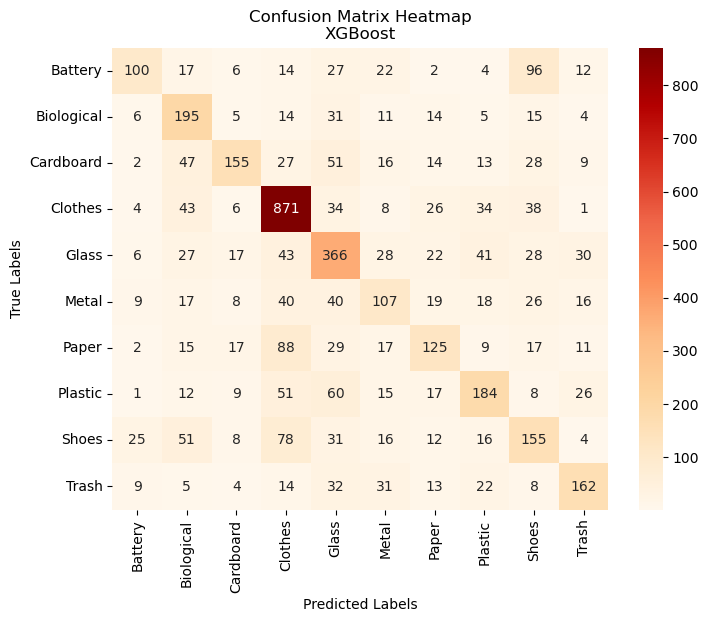

In [18]:
cm = confusion_matrix(test_labels, y_pred)

# Define class labels
labels = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic', 'Shoes', 'Trash']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap\nXGBoost')
plt.show()

In [ ]:
xg_boost_acc = accuracy_score(test_labels, y_pred)
xg_boost_prec = precision_score(test_labels, y_pred)
xg_boost_rec = recall_score(test_labels, y_pred)
xg_boost_f1 = f1_score(test_labels, y_pred)

### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1, gamma='scale')  # Usa kernel RBF per catturare relazioni non lineari
svm.fit(x_train, train_labels)

### Training error for SVM

In [ ]:
y_pred_train = svm.predict(x_train)
print(classification_report(train_labels, y_pred_train))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      1229
           1       0.59      0.44      0.50      1209
           2       0.61      0.45      0.52      1421
           3       0.51      0.95      0.67      4253
           4       0.47      0.50      0.49      2402
           5       0.55      0.21      0.30      1210
           6       0.44      0.32      0.37      1317
           7       0.61      0.24      0.34      1526
           8       0.50      0.21      0.30      1581
           9       0.66      0.55      0.60      1223

    accuracy                           0.53     17371
   macro avg       0.55      0.44      0.47     17371
weighted avg       0.54      0.53      0.50     17371



### Test error for SVM

In [ ]:
y_pred = svm.predict(x_test)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       271
           1       0.57      0.41      0.47       291
           2       0.56      0.32      0.41       389
           3       0.51      0.96      0.67      1070
           4       0.45      0.51      0.48       637
           5       0.37      0.13      0.20       290
           6       0.41      0.29      0.34       333
           7       0.54      0.22      0.31       389
           8       0.43      0.16      0.23       396
           9       0.44      0.41      0.42       277

    accuracy                           0.49      4343
   macro avg       0.47      0.39      0.40      4343
weighted avg       0.48      0.49      0.45      4343



### K-NN

In [19]:
knn = KNeighborsClassifier()
grid_knn = {'n_neighbors':[i for i in range(50, 350, 50)],
            'weights':['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(knn, grid_knn, cv=5, scoring='accuracy', verbose=2)
if grid is not None:
    grid.fit(x_train, train_labels)

    print(f'Best score: {grid.best_score_}')
    for hp, value in grid.best_params_.items():
        print(f'{hp}:{value}\n')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\gabri\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gabri\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\gabri\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gabri\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\gabri\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProce

[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.4s
[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.1s
[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.3s
[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.1s
[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.2s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   1.1s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   1.1s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   1.0s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   0.7s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   0.9s
[CV] END .metric=euclidean, n_neighbors=100, weights=uniform; total time=   1.2s
[CV] END .metric=euclidean, n_neighbors=100, weights=uniform; total time=   1.3s
[CV] END .metric=euclidean, 

In [20]:
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', metric='manhattan')

knn.fit(x_train, train_labels)

KNeighborsClassifier(metric='manhattan', n_neighbors=50, weights='distance')

### Training error for KNN

In [21]:
y_pred_train = knn.predict(x_train)
print(classification_report(train_labels, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1200
           1       1.00      1.00      1.00      1200
           2       1.00      1.00      1.00      1448
           3       1.00      1.00      1.00      4258
           4       1.00      1.00      1.00      2431
           5       1.00      1.00      1.00      1200
           6       1.00      1.00      1.00      1320
           7       1.00      1.00      1.00      1532
           8       1.00      1.00      1.00      1581
           9       1.00      1.00      1.00      1200

    accuracy                           1.00     17370
   macro avg       1.00      1.00      1.00     17370
weighted avg       1.00      1.00      1.00     17370



### Test error for KNN

In [23]:
y_pred = knn.predict(x_test)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.27      0.38       300
           1       0.34      0.62      0.44       300
           2       0.57      0.37      0.45       362
           3       0.56      0.86      0.68      1065
           4       0.40      0.39      0.40       608
           5       0.38      0.14      0.20       300
           6       0.31      0.50      0.38       330
           7       0.60      0.21      0.31       383
           8       0.35      0.29      0.32       396
           9       0.67      0.28      0.40       300

    accuracy                           0.47      4344
   macro avg       0.48      0.39      0.40      4344
weighted avg       0.49      0.47      0.44      4344



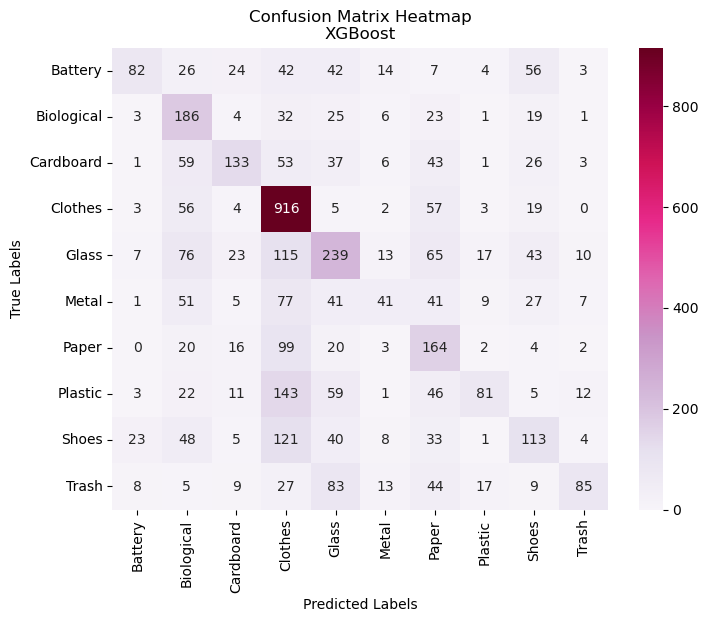

In [24]:
cm = confusion_matrix(test_labels, y_pred)

# Define class labels
labels = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic', 'Shoes', 'Trash']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap\nXGBoost')
plt.show()

In [26]:
knn_acc = accuracy_score(test_labels, y_pred)
knn_prec = precision_score(test_labels, y_pred, average='weighted')
knn_rec = recall_score(test_labels, y_pred, average='weighted')
knn_f1 = f1_score(test_labels, y_pred, average='weighted')

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

grid_tree = {'criterion':['gini', 'entropy', 'log_loss'],
             'splitter' : ['best', 'random'],
             'max_depth': [5, 10, 15]}

grid = GridSearchCV(tree, grid_tree, cv=5, scoring='accuracy', verbose=2)
if grid is not None:
    grid.fit(x_train, train_labels)

    print(f'Best score: {grid.best_score_}')
    for hp, value in grid.best_params_.items():
        print(f'{hp}:{value}\n')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   9.3s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   8.7s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   8.6s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   8.0s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   9.4s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.5s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.6s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.5s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.3s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.2s
[CV] END ........criterion=gini, max_depth=10, splitter=best; total time=  18.0s
[CV] END ........criterion=gini, max_depth=10, s

In [ ]:
tree = DecisionTreeClassifier(criterion='log_loss', max_depth=10, splitter='best')
tree.fit(x_train, train_labels)

DecisionTreeClassifier(criterion='log_loss', max_depth=10)

### Train error

In [ ]:
y_pred_train = tree.predict(x_train)
print(classification_report(train_labels, y_pred_train))

              precision    recall  f1-score   support

           0       0.65      0.60      0.63      1229
           1       0.66      0.66      0.66      1209
           2       0.63      0.55      0.59      1421
           3       0.62      0.86      0.72      4253
           4       0.56      0.62      0.59      2402
           5       0.52      0.32      0.40      1210
           6       0.48      0.50      0.49      1317
           7       0.66      0.50      0.57      1526
           8       0.60      0.39      0.47      1581
           9       0.84      0.66      0.74      1223

    accuracy                           0.62     17371
   macro avg       0.62      0.57      0.59     17371
weighted avg       0.62      0.62      0.61     17371



### Test error

In [ ]:
y_pred = tree.predict(x_test)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.35      0.35       271
           1       0.47      0.48      0.47       291
           2       0.40      0.28      0.33       389
           3       0.57      0.77      0.65      1070
           4       0.36      0.40      0.38       637
           5       0.24      0.16      0.20       290
           6       0.28      0.28      0.28       333
           7       0.36      0.30      0.33       389
           8       0.29      0.20      0.23       396
           9       0.53      0.38      0.44       277

    accuracy                           0.43      4343
   macro avg       0.38      0.36      0.37      4343
weighted avg       0.41      0.43      0.41      4343



In [ ]:
cm = confusion_matrix(test_labels, y_pred)

# Define class labels
labels = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic', 'Shoes', 'Trash']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap\nXGBoost')
plt.show()

In [ ]:
tree_acc = accuracy_score(test_labels, y_pred)
tree_prec = precision_score(test_labels, y_pred, average='weighted')
tree_rec = recall_score(test_labels, y_pred, average = 'weighted')
tree_f1 = f1_score(test_labels, y_pred, average='weighted')

## Preprocessing with Autoencoders

In [3]:
# Trasformazioni delle immagini
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona le immagini
    transforms.ToTensor(),         # Converti in tensore
])

# Carica il dataset
dataset_path = "/content/FDS-project/data"
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Crea un DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Visualizza le classi
print(train_dataset.classes)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [5]:
# Percorso alla directory principale del dataset
dataset_path = "/content/FDS-project/data"

# Crea DataLoader per train, validation e test set
train_loader, val_loader, test_loader = create_dataloaders(
    dataset_path=dataset_path,
    train_split=0.8,  # 70% per il training
    val_split=0.0,    # 20% per la validazione
    test_split=0.2,   # 10% per il test
    batch_size=32     # Dimensione del batch
)

# Verifica il numero di campioni
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 17371
Validation set size: 0
Test set size: 4343


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona le immagini
    transforms.ToTensor(),         # Converte in tensori
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizzazione
])

In [ ]:
# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # Flatten l'immagine
        x = x.view(x.size(0), -1)
        encoded = torch.relu(self.encoder(x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return encoded, decoded

# Dimensione dell'input
input_size = 3 * 224 * 224  # Aggiorna in base alla risoluzione delle immagini
hidden_size = 64  # Numero di neuroni nascosti

autoencoder = SparseAutoencoder(input_size, hidden_size)

In [9]:
train_features, train_labels = extract_features(autoencoder, train_loader)
test_features, test_labels = extract_features(autoencoder, test_loader)

In [ ]:
rnd = RandomForestClassifier()
grid_rnd = {'n_estimators':[i for i in range(50, 250, 50)],
            'max_depth':[j for j in range(5, 20, 5)],
            'max_leaf_nodes': [5, 10, 15]}

grid = GridSearchCV(rnd, grid_rnd, cv=5, scoring='accuracy', verbose=2)
if grid is not None:
    grid.fit(train_features, train_labels)

    print(f'Best score: {grid.best_score_}')
    for hp, value in grid.best_params_.items():
        print(f'{hp}:{value}\n')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .....max_depth=5, max_leaf_nodes=5, n_estimators=50; total time=   2.5s
[CV] END .....max_depth=5, max_leaf_nodes=5, n_estimators=50; total time=   1.4s
[CV] END .....max_depth=5, max_leaf_nodes=5, n_estimators=50; total time=   1.1s
[CV] END .....max_depth=5, max_leaf_nodes=5, n_estimators=50; total time=   1.1s
[CV] END .....max_depth=5, max_leaf_nodes=5, n_estimators=50; total time=   1.1s
[CV] END ....max_depth=5, max_leaf_nodes=5, n_estimators=100; total time=   2.1s
[CV] END ....max_depth=5, max_leaf_nodes=5, n_estimators=100; total time=   2.1s
[CV] END ....max_depth=5, max_leaf_nodes=5, n_estimators=100; total time=   2.8s
[CV] END ....max_depth=5, max_leaf_nodes=5, n_estimators=100; total time=   2.5s
[CV] END ....max_depth=5, max_leaf_nodes=5, n_estimators=100; total time=   2.1s
[CV] END ....max_depth=5, max_leaf_nodes=5, n_estimators=150; total time=   3.2s
[CV] END ....max_depth=5, max_leaf_nodes=5, n_e

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best score: 0.3500655475619504
max_depth:15

max_leaf_nodes:15

n_estimators:50



In [ ]:
rnd = RandomForestClassifier(n_estimators=100, random_state=42)

rnd.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

### Train error

In [ ]:
labels_pred_train = rnd.predict(train_features)
print(classification_report(train_labels, labels_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1195
           1       1.00      1.00      1.00      1213
           2       1.00      1.00      1.00      1461
           3       1.00      1.00      1.00      4261
           4       1.00      1.00      1.00      2428
           5       1.00      1.00      1.00      1210
           6       1.00      1.00      1.00      1319
           7       1.00      1.00      1.00      1516
           8       1.00      1.00      1.00      1589
           9       1.00      1.00      1.00      1179

    accuracy                           1.00     17371
   macro avg       1.00      1.00      1.00     17371
weighted avg       1.00      1.00      1.00     17371



### Test error

In [ ]:
labels_pred = rnd.predict(test_features)
print(classification_report(test_labels, labels_pred))

              precision    recall  f1-score   support

           0       0.54      0.40      0.46       305
           1       0.49      0.32      0.39       287
           2       0.60      0.52      0.56       349
           3       0.53      0.94      0.68      1062
           4       0.51      0.56      0.53       611
           5       0.43      0.13      0.20       290
           6       0.68      0.43      0.52       331
           7       0.67      0.40      0.50       399
           8       0.38      0.20      0.26       388
           9       0.55      0.55      0.55       321

    accuracy                           0.54      4343
   macro avg       0.54      0.45      0.47      4343
weighted avg       0.54      0.54      0.51      4343

